# How to save a LightCurve in FITS format?

Once you have detrended or altered a lightcurve in some way, you may want to save it as a FITS file. This allows you to easily share the file with your collaborators or submit your lightcurves as a [MAST High Level Science Product](https://archive.stsci.edu/hlsp/hlsp_guidelines.html) (HLSP). Lightkurve provides a [to_fits()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.to_fits.html) method which will easily convert your [LightCurve](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.html) object into a fits file.

Below is a brief demostration showing how `to_fits()` works.

Note: if you are considering contributing a HLSP you may want to read the [guidelines](https://outerspace.stsci.edu/display/MASTDOCS/HLSP+How-To+Guide) for contributing fits files. These include which fits headers are required/suggested for your HLSP to be accepted.

## Example: editing and writing a lightcurve

First we'll obtain a random Kepler lightcurve from MAST.

In [1]:
%matplotlib inline
from lightkurve import search_lightcurve
lc = search_lightcurve('KIC 757076', author="Kepler", quarter=3).download()

/Users/nthom/lightkurve/src/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Now we'll make some edits to the lightcurve. Below we use the PDCSAP flux from MAST, remove NaN values using the [.remove_nans()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.remove_nans.html) function, and clip out any outliers using the [.remove_outliers()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.remove_outliers.html).

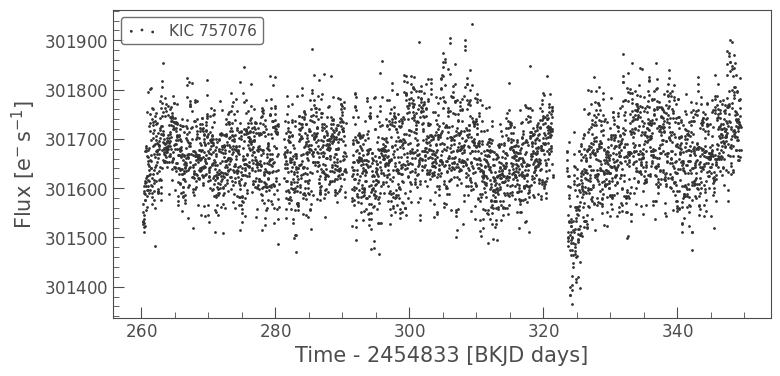

In [2]:
lc = lc.remove_nans().remove_outliers()
lc.scatter();

Now we can use the `to_fits` method to save the lightcurve to a file called *output.fits*.

In [3]:
lc.to_fits(path='demo-lightcurve.fits', overwrite=True)

Let's take a look at the file and check that it behaved as we expect

In [4]:
from astropy.io import fits
hdu = fits.open('demo-lightcurve.fits')
type(hdu)

astropy.io.fits.hdu.hdulist.HDUList

In [5]:
hdu.info()

Filename: demo-lightcurve.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  LIGHTCURVE    1 BinTableHDU     28   4133R x 7C   [D, E, E, J, K, D, D]   


`hdu` is a set of astropy.io.fits objects, which is what we would expect. Lets take a look at the header of the first extension.

In [6]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'Unofficial data product' / institution responsible for file          
DATE    = '2025-03-05'         / file creation date.                            
CREATOR = 'lightkurve.LightCurve.to_fits()' / pipeline job and program used t   
TELESCOP= 'KEPLER  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
OBJECT  = '757076  '        

Looks like it has all the correct information about the target. What about the second extension?

In [7]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   44 / length of dimension 1                          
NAXIS2  =                 4133 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'TIME    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'bkjd    '                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'E       '        

This extension has 7 columns, `TIME`, `FLUX`, `FLUX_ERR`, `SAP_QUALITY`, `CADENCENO`, `MOM_CENTR1`, and `MOM_CENTR2`.  What if we wanted to add new keywords to our fits file?  HLSP products require some extra keywords. Let's add some keywords to explain who made the data, and what our HLSP is. 

In [8]:
lc.to_fits(path='demo-lightcurve.fits',
           overwrite=True,
           HLSPLEAD='Kepler/K2 GO office',
           HLSPNAME='TUTORIAL',
           CITATION='HEDGES2018')

In [9]:
hdu = fits.open('demo-lightcurve.fits')

In [10]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'Unofficial data product' / institution responsible for file          
DATE    = '2025-03-05'         / file creation date.                            
CREATOR = 'lightkurve.LightCurve.to_fits()' / pipeline job and program used t   
TELESCOP= 'KEPLER  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
OBJECT  = '757076  '        

Now our new keywords are included in the primary header! What about if we want to add more **data columns** to our fits file? We can simply add data columns in the same way. Let's add the data quality to our fits file.

In [11]:
demo_vector = lc.fold(period=1.23456789).phase
demo_vector

<TimeDelta object: scale='None' format='jd' value=[-0.61680215 -0.61654885 -0.61577695 ...  0.61676757  0.61705094
  0.61726379]>

In [12]:
lc.to_fits(path='demo-lightcurve.fits',
           overwrite=True,
           HLSPLEAD='Kepler/K2 GO office',
           HLSPNAME='TUTORIAL',
           CITATION='HEDGES2018',
           DEMO_COLUMN=demo_vector.value)

In [13]:
hdu = fits.open('demo-lightcurve.fits')

In [14]:
hdu[1].data.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'bkjd'
    name = 'FLUX'; format = 'E'; unit = 'electron / s'
    name = 'FLUX_ERR'; format = 'E'; unit = 'electron / s'
    name = 'CADENCENO'; format = 'J'
    name = 'DEMO_COLUMN'; format = 'D'
    name = 'SAP_QUALITY'; format = 'K'
    name = 'MOM_CENTR1'; format = 'D'
    name = 'MOM_CENTR2'; format = 'D'
)

The vector is populated as a data column in the HDU extension.  Once all your lightcurves are saved as fits files and you have a README file, you can consider submitting your data products to MAST.